# Requirements

In [1]:
import pandas as pd
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df1 = pd.read_excel('queried_samples.xlsx')
df2 = pd.read_csv('majority_votes.csv')
merged_df = pd.merge(df1, df2, on='request-id')

# Convincingness per Dataset

In [3]:
convincingness_per_dataset = merged_df.groupby('dataset-name')['convincing'].agg(['mean', 'count'])
convincingness_per_dataset['mean'] *= 100
convincingness_per_dataset

,mean,count
dataset-name,,
halle,54.931071,943
nl2bash,40.119760,334
prague,64.341085,129


# Base Command Convincingness

In [4]:
pivot_df = pd.pivot_table(merged_df, values='convincing', index='base-command', columns='dataset-name', aggfunc='mean')

pivot_df = pivot_df.rename(columns=lambda x: f'Mean Convincingness ({x})')
pivot_df *= 100

grouped = merged_df.groupby('base-command')['convincing'].agg(['mean', 'count'])
grouped['mean'] *= 100

In [5]:
final_df = grouped.join(pivot_df)
final_df = final_df.rename(columns={'mean': 'Overall Percentage of Convincing', 'count': 'Count of Instances'})
filtered_df = final_df[final_df['Count of Instances'] >= 20]
filtered_df = filtered_df[
    filtered_df[['Mean Convincingness (halle)', 'Mean Convincingness (nl2bash)', 'Mean Convincingness (prague)']].notna().sum(axis=1) >= 2
]
result_df = filtered_df.sort_values(by='Overall Percentage of Convincing', ascending=True)

result_df

,Overall Percentage of Convincing,Count of Instances,Mean Convincingness (halle),Mean Convincingness (nl2bash),Mean Convincingness (prague)
base-command,,,,,
w,4.347826,23,4.545455,0.000000,NaN
wget,8.163265,49,6.976744,0.000000,20.000000
top,17.391304,23,13.636364,100.000000,NaN
rm,45.588235,68,43.939394,100.000000,100.000000
curl,50.000000,26,40.000000,100.000000,80.000000
cd,57.017544,114,56.880734,0.000000,100.000000
ls,63.888889,36,90.000000,33.333333,56.521739
echo,64.935065,77,64.179104,66.666667,75.000000
cat,66.257669,163,61.764706,50.000000,95.652174


# Complexity Analysis

In [6]:
df_halle = merged_df[(merged_df['dataset-name'] == 'halle')]
df_nl2bash = merged_df[(merged_df['dataset-name'] == 'nl2bash')]
df_prague = merged_df[(merged_df['dataset-name'] == 'prague')]

In [7]:
special_chars_groups = {
    'All special characters': ['<', '>', '|', '&', ';', '$', '{','}','[',']', '(', ')', '*'],
    'Top 5 special characters': [';', '$', '|', '&', '<'],
    'Command Separators': [';', '&&', '||'],
    'Substitution': ['$'],
    'Brackets': ['(',')','[',']','{','}'],
    'Piping': ['|'],
    'Redirection': ['<', '>'],
    'Job control': ['&'],
    'Flags': ['-'],
    'Semicolon': [';'],
    'Wildcard': ['*'],
    'Parentheses': ['(', ')'],
    'Square Brackets': ['[', ']'],
    'Braces': ['{', '}'],
}

In [8]:
def count_special_chars(command, chars, exclude_doubles=False):
    if exclude_doubles:
        command = command.replace('&&', '').replace('||', '')
    return sum(1 for char in command if char in chars)

def process_dataframe(df, special_chars_groups):
    df_copy = df.copy()
    for group, chars in special_chars_groups.items():
        exclude_doubles = group in ['Piping', 'Job control']
        df_copy[group] = df_copy['commands'].apply(lambda x: count_special_chars(x, chars, exclude_doubles))
    return df_copy

df_halle_special_char_counts = process_dataframe(df_halle, special_chars_groups)
df_nl2bash_special_char_counts = process_dataframe(df_nl2bash, special_chars_groups)
df_prague_special_char_counts = process_dataframe(df_prague, special_chars_groups)
merged_df_special_char_counts = process_dataframe(merged_df, special_chars_groups)

In [9]:
def count_rows_with_special_chars(df, special_chars_groups):
    summary = {'Group': [], 'count convincing': [], 'count not-convincing': []}
    
    for group in special_chars_groups.keys():
        convincing_count = df[(df[group] > 0) & (df['convincing'] == True)].shape[0]
        not_convincing_count = df[(df[group] > 0) & (df['convincing'] == False)].shape[0]
        
        summary['Group'].append(group)
        summary['count convincing'].append(convincing_count)
        summary['count not-convincing'].append(not_convincing_count)
    
    return pd.DataFrame(summary)

summary_halle = count_rows_with_special_chars(df_halle_special_char_counts, special_chars_groups)
summary_nl2bash = count_rows_with_special_chars(df_nl2bash_special_char_counts, special_chars_groups)

summary_merged_df = count_rows_with_special_chars(merged_df_special_char_counts, special_chars_groups)

In [10]:
def add_correlations(df, summary_df, special_chars_groups):
    summary_df['kendall_corr'] = 0.0
    summary_df['kendall_p'] = 0.0

    for index, row in summary_df.iterrows():
        group = row['Group']
        
        kendall_corr, kendall_p = stats.kendalltau(df[group], df['convincing'])
        
        summary_df.at[index, 'kendall_corr'] = kendall_corr
        summary_df.at[index, 'kendall_p'] = kendall_p

add_correlations(df_halle_special_char_counts, summary_halle, special_chars_groups)
add_correlations(df_nl2bash_special_char_counts, summary_nl2bash, special_chars_groups)
add_correlations(merged_df_special_char_counts, summary_merged_df, special_chars_groups)

#summary_nl2bash
#summary_halle
summary_merged_df

,Group,count convincing,count not-convincing,kendall_corr,kendall_p
0,All special characters,389,488,-0.212356,1.509378e-19
1,Top 5 special characters,317,469,-0.212100,6.285277e-19
2,Command Separators,117,196,-0.162526,2.142070e-10
3,Substitution,63,107,-0.107129,3.988442e-05
4,Brackets,84,127,-0.111656,1.908295e-05
5,Piping,173,252,-0.127385,5.626033e-07
6,Redirection,92,171,-0.164688,2.100064e-10
7,Job control,72,116,-0.116813,8.068815e-06
8,Flags,454,467,-0.169761,1.728858e-12
9,Semicolon,117,196,-0.162526,2.142070e-10


In [11]:
merged_df_special_char_counts['length'] = merged_df_special_char_counts['commands'].apply(lambda x: len(str(x)))
df_halle_special_char_counts['length'] = df_halle_special_char_counts['commands'].apply(lambda x: len(str(x)))
df_nl2bash_special_char_counts['length'] = df_nl2bash_special_char_counts['commands'].apply(lambda x: len(str(x)))
df_prague_special_char_counts['length'] = df_prague_special_char_counts['commands'].apply(lambda x: len(str(x)))

In [12]:
def descriptive_analysis(df):
    print("Descriptive Statistics:")
    print(df.describe())

In [13]:
print("Overall:")
descriptive_analysis(merged_df_special_char_counts[['convincing', 'All special characters', 'length']])
print("\nPrague:")
descriptive_analysis(df_prague_special_char_counts[['convincing', 'All special characters', 'length']])
print("\nNl2Bash:")
descriptive_analysis(df_nl2bash_special_char_counts[['convincing', 'All special characters', 'length']])
print("\nHalle:")
descriptive_analysis(df_halle_special_char_counts[['convincing', 'All special characters', 'length']])

Overall:
Descriptive Statistics:
        convincing  All special characters        length
count  1406.000000             1406.000000   1406.000000
mean      0.522760                7.889758    204.002845
std       0.499659               86.217155   1920.317618
min       0.000000                0.000000      1.000000
25%       0.000000                0.000000     14.250000
50%       1.000000                1.000000     35.000000
75%       1.000000                4.000000     70.000000
max       1.000000             2105.000000  32767.000000

Prague:
Descriptive Statistics:
       convincing  All special characters      length
count  129.000000              129.000000  129.000000
mean     0.643411                0.155039   13.426357
std      0.480859                0.536913    9.277640
min      0.000000                0.000000    2.000000
25%      0.000000                0.000000    7.000000
50%      1.000000                0.000000   12.000000
75%      1.000000                0.000000  

In [14]:
kendall_corr, kendall_p = stats.kendalltau(merged_df_special_char_counts['length'], merged_df_special_char_counts['convincing'])
kendall_corr
#kendall_p

np.float64(-0.21549296228639928)

In [15]:
def calculate_convincingness(df, group_name, threshold=3):
    filtered_df = df[df[group_name] > threshold]
    counts = filtered_df.groupby('convincing').size()
    
    count_convincing = counts.get(1, 0)
    count_not_convincing = counts.get(0, 0)
    
    total = count_convincing + count_not_convincing
    convincingness_percentage = (count_convincing / total) * 100 if total > 0 else 0
    
    return count_convincing, count_not_convincing, convincingness_percentage

def create_convincingness_table(df, special_chars_groups, threshold=3):
    table_data = []
    
    for group_name in special_chars_groups.keys():
        count_convincing, count_not_convincing, convincingness_percentage = calculate_convincingness(df, group_name, threshold)
        table_data.append({
            'Group': group_name,
            'Count Convincing': count_convincing,
            'Count Not-Convincing': count_not_convincing,
            'Convincingness (%)': convincingness_percentage
        })
    
    convincingness_table = pd.DataFrame(table_data)
    return convincingness_table

convincingness_table_merged = create_convincingness_table(merged_df_special_char_counts, special_chars_groups)
convincingness_table_merged

,Group,Count Convincing,Count Not-Convincing,Convincingness (%)
0,All special characters,170,261,39.443155
1,Top 5 special characters,144,179,44.582043
2,Command Separators,8,51,13.559322
3,Substitution,33,34,49.253731
4,Brackets,18,64,21.951220
5,Piping,6,21,22.222222
6,Redirection,3,25,10.714286
7,Job control,0,4,0.000000
8,Flags,40,106,27.397260
9,Semicolon,8,51,13.559322


In [16]:
def calculate_convincingness_for_length(df):
    length_threshold = df['length'].median()
    filtered_df = df[df['length'] > length_threshold]
    
    counts = filtered_df.groupby('convincing').size()
    
    count_convincing = counts.get(1, 0)
    count_not_convincing = counts.get(0, 0)
    
    total = count_convincing + count_not_convincing
    convincingness_percentage = (count_convincing / total) * 100 if total > 0 else 0
    
    print(f"Count Convincing: {count_convincing}") 
    print(f"Count not-Convincing: {count_not_convincing}") 
    print(f"Convincingness %: {convincingness_percentage}")

print("Overall:")
calculate_convincingness_for_length(merged_df_special_char_counts)
print("Halle:")
calculate_convincingness_for_length(df_halle_special_char_counts)
print("NL2Bash:")
calculate_convincingness_for_length(df_nl2bash_special_char_counts)
print("Prague:")
calculate_convincingness_for_length(df_prague_special_char_counts)


Overall:
Count Convincing: 274
Count not-Convincing: 427
Convincingness %: 39.08701854493581
Halle:
Count Convincing: 184
Count not-Convincing: 285
Convincingness %: 39.23240938166311
NL2Bash:
Count Convincing: 51
Count not-Convincing: 108
Convincingness %: 32.075471698113205
Prague:
Count Convincing: 36
Count not-Convincing: 25
Convincingness %: 59.01639344262295


In [17]:
df_halle_special_char_counts['log_special_chars'] = np.log1p(df_halle_special_char_counts['All special characters'])
df_nl2bash_special_char_counts['log_special_chars'] = np.log1p(df_nl2bash_special_char_counts['All special characters'])
df_prague_special_char_counts['log_special_chars'] = np.log1p(df_prague_special_char_counts['All special characters'])

df_halle_special_char_counts['log_length'] = np.log1p(df_halle_special_char_counts['length'])
df_nl2bash_special_char_counts['log_length'] = np.log1p(df_nl2bash_special_char_counts['length'])
df_prague_special_char_counts['log_length'] = np.log1p(df_prague_special_char_counts['length'])

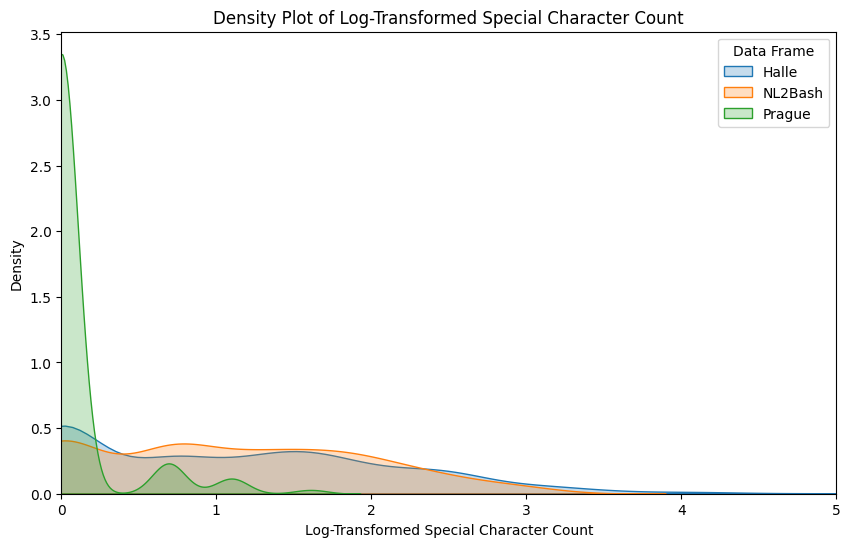

In [18]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_halle_special_char_counts['log_special_chars'], label='Halle', fill=True)
sns.kdeplot(data=df_nl2bash_special_char_counts['log_special_chars'], label='NL2Bash', fill=True)
sns.kdeplot(data=df_prague_special_char_counts['log_special_chars'], label='Prague', fill=True)
plt.xlim(0, 5)
plt.title('Density Plot of Log-Transformed Special Character Count')
plt.xlabel('Log-Transformed Special Character Count')
plt.ylabel('Density')
plt.legend(title='Data Frame')
plt.show()


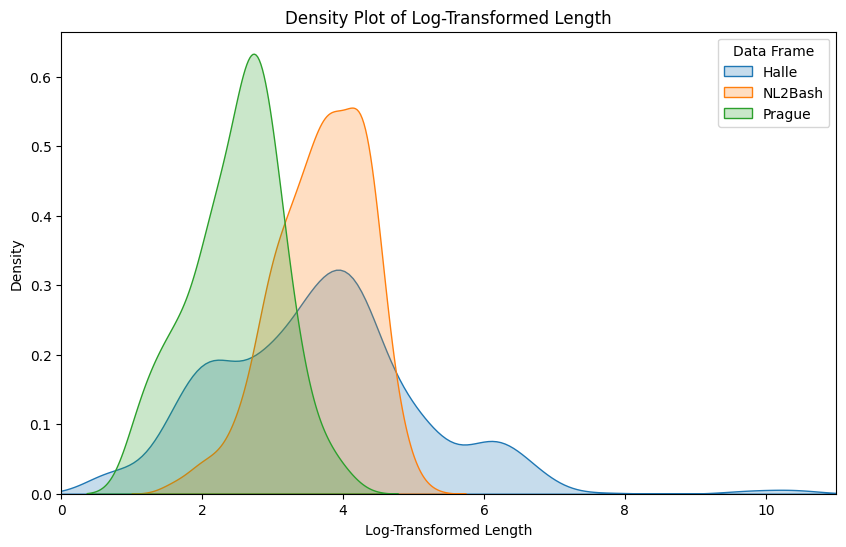

In [19]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_halle_special_char_counts['log_length'], label='Halle', fill=True)
sns.kdeplot(data=df_nl2bash_special_char_counts['log_length'], label='NL2Bash', fill=True)
sns.kdeplot(data=df_prague_special_char_counts['log_length'], label='Prague', fill=True)
plt.xlim(0, 11)
plt.title('Density Plot of Log-Transformed Length')
plt.xlabel('Log-Transformed Length')
plt.ylabel('Density')
plt.legend(title='Data Frame')
plt.show()